In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Function to determine probability of switching

In [5]:
def probability_at_time(pc, n_coop_cur, n_coop_pop, n_trials_cur, n_trials_pop, pop_info): # p is probability of current partner coop; n_total is the number of trials
    a = 1
    b = 1

    pc = pc
    switch_fit_multiplier = 1

    T = 0.8 # D / C
    R = 0.6 # C / C
    P = 0.2 # D / D
    S = 0.4 # C / D
    
    population_a = a + pop_info * n_coop_pop
    population_b = b + pop_info * (n_trials_pop - n_coop_pop)
        
    current_a = population_a + n_coop_cur
    current_b = population_b + (n_trials_cur - n_coop_cur)

    samples_current = stats.beta.rvs(current_a, current_b, size=10000)
    samples_population = stats.beta.rvs(population_a, population_b, size=10000)

    staying_fitness =  (
            samples_current * (pc * R + (1 - pc) * T) +
            (1 - samples_current) * (pc * S + (1 - pc) * P)
        )

    switching_fitness =  (
            samples_population * (pc * R + (1 - pc) * T) +
            (1 - samples_population) * (pc * S + (1 - pc) * P)
        )

    payoff_difference = (switching_fitness * switch_fit_multiplier) - staying_fitness
    ps = np.mean(payoff_difference > 0) # expectation that switching is better than staying
    
    payoff = ps * (switching_fitness * switch_fit_multiplier) + (1 - ps) * staying_fitness # expected payoff
    
    return list([np.mean(payoff), ps, samples_current, samples_population, np.std(payoff)])

# Model components

In [6]:
class Population:
    def __init__(self):
        self.animals = []

    def attach_animal(self, animal):
        self.animals.append(animal)
        animal.population = self

    def summary(self):
        return [animal.summary() for animal in self.animals]

class Animal:
    def __init__(self, id, pc):
        # Identity and behaviour
        self.id = id
        self.pc = pc

        # Data
        self.n_partners = 0
        self.n_partners_switched_from = 0

        # For use in model
        self.payoff = 0
        self.partner = None
        self.n_coop_cur = 0
        self.n_coop_pop = 0
        self.n_trials_cur = 0
        self.n_trials_pop = 0

        self.population = None

    def step(self, i):
        # self.n_steps += 1
        if self.partner is None:
            if np.random.uniform(0, 1) < 0.5:
                self._find_new_partner()
            else:
                payoff = 0.4
                self.payoff = payoff

        if self.partner is not None:
            result = probability_at_time(self.pc, self.n_coop_cur, self.n_coop_pop, self.n_trials_cur, self.n_trials_pop, M) # probability of switching and payoff

            self.n_coop_cur += round(self.partner.pc, 0) # binarise cooperation -- does current partner cooperate or not?
            self.n_coop_pop += round(self.partner.pc, 0) 
            self.n_trials_cur += 1
            self.n_trials_pop += 1

            prob = result[1] # probability of self switching

            if prob > np.random.uniform(0, 1): # if probability of self switching high enough, find new partner
                self._find_new_partner()
            
            self._calculate_payoff()
            
            if self.payoff < np.random.uniform(0, 1): # if payoff is too low, animal dies
                self._reset() # remove all animal's attributes
                potential_parents = self.population.animals.copy()
                potential_parents.remove(self)
                parent = np.random.choice(potential_parents)
                self.pc = parent.pc + np.random.normal(0, 0.1)
                timer = 0
                while self.pc > 1 or self.pc < 0 and timer < 100:
                    self.pc = parent.pc + np.random.normal(0, 0.1)
                    timer += 1
                if self.pc > 1:
                    self.pc = 1
                elif self.pc < 0:
                    self.pc = 0

    def _calculate_payoff(self):
        payoff = 0
        if round(self.partner.pc, 0) == 1: # if my partner cooperates
            if self.pc > np.random.uniform(0, 1):
                payoff = 0.6
            else:
                payoff = 0.8
        elif round(self.partner.pc, 0) == 0: # if my partner defects
            if self.pc > np.random.uniform(0, 1):
                payoff = 0.4
            else:
                payoff = 0.2
        self.payoff = payoff

    def _find_new_partner(self):
        candidate_partners = self.population.animals.copy()
        candidate_partners.remove(self)
        if self.partner is not None: # if animal has a partner, remove partner
            self.partner.n_partners_switched_from += 1
            candidate_partners.remove(self.partner)
            self.partner.partner = None
            self.partner = None
        for animal in candidate_partners: # if potential partner has a partner, remove potential partner from candidate partners
                if animal.partner is not None:
                    candidate_partners.remove(animal)

        if len(candidate_partners) > 0: # if there are potential partners, choose one
            self.partner = np.random.choice(candidate_partners)
            self.partner.partner = self
            self.n_partners += 1
            self.n_coop_cur = 0
            self.n_trials_cur = 0
        else: # if there are no potential partners, stay alone :(
            self.partner = None
            print("No partners available")

    def _reset(self):
        self.partner.partner = None

        self.partner = None
        self.n_coop_cur = 0
        self.n_coop_pop = 0
        self.n_trials_cur = 0
        self.n_trials_pop = 0
        self.n_partners = 0
        self.n_partners_switched_from = 0
        self.n_steps = 0

    def summary(self):
        return {
            'id': self.id,
            'pc': self.pc,
            'partner': self.partner.id if self.partner is not None else None,
            'n_partners': self.n_partners
        }
    

# Model run

/Users/xy24823/miniconda3/envs/bayesian_switching/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/xy24823/miniconda3/envs/bayesian_switching/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/xy24823/miniconda3/envs/bayesian_switching/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/xy24823/miniconda3/envs/bayesian_switching/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/xy24823/miniconda3/envs/bayesian_switching/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  

Text(0, 0.5, 'Mean number of partners')

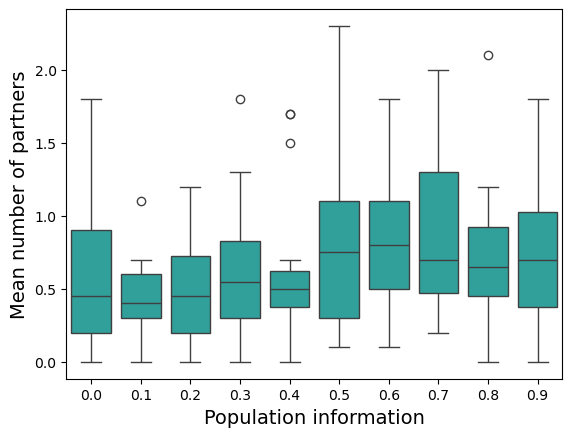

In [9]:
all_mean_n_partners = []
all_std_n_partners = []
all_uncertainty = []
all_mean_pc = []
all_std_pc = []
all_pop_pc_dist = []
all_iterations = []
all_mean_payoff = []
all_std_payoff = []
all_mean_partner_pc = []
all_std_partner_pc = []
all_steps = []
all_mean_switched_from = []
all_rsquared_asstmnt = []
all_coef_asstmnt = []
all_rsquared_payoff = []
all_coef_payoff = []

pop_info = np.arange(0, 1, 0.1)

num_iterations = 20
num_timesteps = 10000
for M in pop_info:
    for j in np.arange(0, num_iterations):
        population_size = 10
        population = Population()

        for id in range(population_size):
            population.attach_animal(Animal(id, stats.beta.rvs(3, 3, size=1)[0])) 

        for i in range(num_timesteps):
            animal = np.random.choice(population.animals)
            animal.step(i)

        mean_n_partners = np.mean([animal.n_partners for animal in population.animals]) # calculate data means for the populations
        # std_n_partners = np.std([animal.n_partners for animal in population.animals])
        mean_n_switched_from = np.mean([animal.n_partners_switched_from for animal in population.animals])
        mean_pc = np.mean([animal.pc for animal in population.animals])
        std_pc = np.std([animal.pc for animal in population.animals])
        # mean_payoff = np.mean([animal.payoff[-1] if len(animal.payoff) > 0 else 0 for animal in population.animals]) # calculate mean payoff, if animal has no payoff, set to 0
        # std_payoff = np.std([animal.payoff[-1] if len(animal.payoff) > 0 else 0 for animal in population.animals])
        mean_partner_pc = np.mean([animal.partner.pc for animal in population.animals if animal.partner is not None])
        std_partner_pc = np.std([animal.partner.pc for animal in population.animals if animal.partner is not None])

        all_mean_n_partners.append(mean_n_partners) # add data to lists
        # all_std_n_partners.append(std_n_partners)
        all_mean_switched_from.append(mean_n_switched_from)
        all_mean_pc.append(mean_pc)
        # all_std_pc.append(std_pc)
        all_uncertainty.append(M)
        all_iterations.append(j)
        # all_mean_payoff.append(mean_payoff)
        # all_std_payoff.append(std_payoff)
        all_mean_partner_pc.append(mean_partner_pc)

# df = pd.DataFrame({'iteration': all_iterations, 'all_uncertainty': all_uncertainty, 'mean_number_partners': all_mean_n_partners, 'sd_number_partners': all_std_n_partners, 'mean_pc': all_mean_pc, 'sd_pc': all_std_pc, 'mean_payoff': all_mean_payoff, 'sd_payoff': all_std_payoff, 'mean_partner_pc': all_mean_partner_pc, 'mean_partner_sd': all_std_partner_pc, 'mean_switched_from': all_mean_switched_from})
df = pd.DataFrame({'iteration': all_iterations, 'all_uncertainty': all_uncertainty, 'mean_number_partners': all_mean_n_partners, 'mean_pc': all_mean_pc, 'mean_partner_pc': all_mean_partner_pc, 'mean_switched_from': all_mean_switched_from})

# write to csv
# game = 'SD'
# df.to_csv('data/Final/{}/data.csv'.format(game), index=False)

p = sns.boxplot(data=df, x=round(df['all_uncertainty'], 1), y=df['mean_number_partners'], color="lightseagreen")
# ax.fill_between(agg_df['all_uncertainty'], agg_df['lower'], agg_df['upper'], alpha=0.5, color="teal")
p.set(xlabel='Population information', ylabel='Mean number of partners')
# change the size of the axis labels font
p.set_xlabel('Population information', fontsize=14)
p.set_ylabel('Mean number of partners', fontsize=14)


The mean number of partners is really low because they keep dying and so I'm guessing the individuals represented in this figure haven't been around for very long. We need to figure out if this is the case and if so how we can get a measure from this model that is comparable with the other -- do we actually need to get them to learn p? This might be quite different.